In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

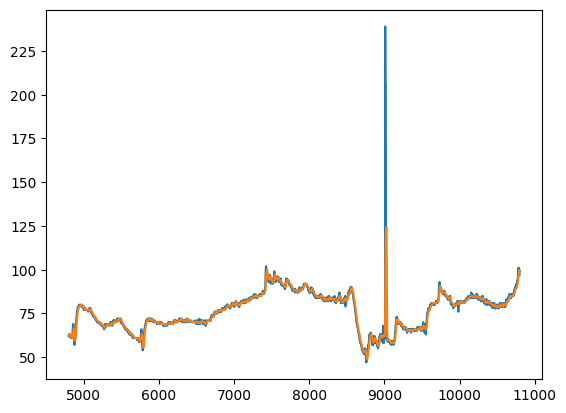

In [2]:
case = 6311
sampling_time = 2
df = pd.read_parquet(f'data/cases/case-{case:04d}.parquet')
df['signal'] = df['Solar8000/ART_MBP']#.interpolate()
# df.signal.bfill(inplace=True)

df['Time'] = df['Time'].astype('timedelta64[s]')
df = df.resample(f'{sampling_time}s', on='Time').last().reset_index()

df['Time'] = df['Time'].dt.total_seconds()

df['signal_smooth'] = df['signal'].rolling(10, min_periods=1).mean()

Time_min = 60*60+20*60
Time_max = 60*60*3
df_plot = df[(df['Time'] > Time_min) & (df['Time'] < Time_max)]
plt.plot(df_plot['Time'], df_plot['signal'])

plt.plot(df_plot['Time'], df_plot['signal_smooth'])
plt.show()

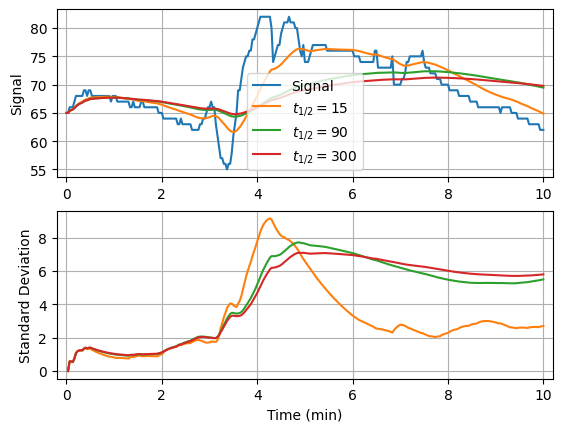

In [3]:


time_start = 1*60*60 + 10*60
time_end = time_start + 10*60

df = df[(df['Time'] >= time_start) & (df['Time'] <= time_end)]
df['Time'] -= time_start



half_times = [30, 3*60, 10*60]

# resample by keeping the last value


half_times = [int(half_time/sampling_time) for half_time in half_times]

df['exp_1'] = df['signal'].ewm(halflife=half_times[0]).mean()
df['exp_2'] = df['signal'].ewm(halflife=half_times[1]).mean()
df['exp_3'] = df['signal'].ewm(halflife=half_times[2]).mean()

df['exp_1_std'] = df['signal'].ewm(halflife=half_times[0]).std()
df['exp_2_std'] = df['signal'].ewm(halflife=half_times[1]).std()
df['exp_3_std'] = df['signal'].ewm(halflife=half_times[2]).std()

df.to_csv('exponential_smoothing.csv', index=False)

plt.subplot(2, 1, 1)
plt.plot(df['Time']/60, df['signal'], label='Signal')
plt.plot(df['Time']/60, df['exp_1'], label=f'$t_{{1/2}}={half_times[0]}$')
plt.plot(df['Time']/60, df['exp_2'], label=f'$t_{{1/2}}={half_times[1]}$')
plt.plot(df['Time']/60, df['exp_3'], label=f'$t_{{1/2}}={half_times[2]}$')
plt.grid()
plt.legend()
plt.xlim(-0.2, 10.2)
plt.ylabel('Signal')
plt.subplot(2, 1, 2)
plt.xlim(-0.2, 10.2)
plt.plot(df['Time']/60, df['exp_1_std']*np.nan)
plt.plot(df['Time']/60, df['exp_1_std'], label=f'$t_{{1/2}}={half_times[0]}$')
plt.plot(df['Time']/60, df['exp_2_std'], label=f'$t_{{1/2}}={half_times[1]}$')
plt.plot(df['Time']/60, df['exp_3_std'], label=f'$t_{{1/2}}={half_times[2]}$')
plt.ylabel('Standard Deviation')
plt.xlabel('Time (min)')
plt.grid()
plt.show()

$t_{1/2}=15$
Coefficients: -0.1557142857142855
Intercept: 62.574285714285715
$t_{1/2}=90$
Coefficients: -0.12948018273860973
Intercept: 62.605318352059925
$t_{1/2}=300$
Coefficients: 0.010822920254669487
Intercept: 71.40684949832776


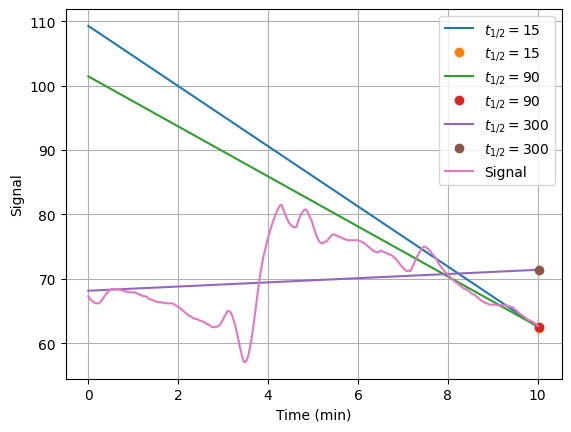

array([[-300],
       [-299],
       [-298],
       [-297],
       [-296],
       [-295],
       [-294],
       [-293],
       [-292],
       [-291],
       [-290],
       [-289],
       [-288],
       [-287],
       [-286],
       [-285],
       [-284],
       [-283],
       [-282],
       [-281],
       [-280],
       [-279],
       [-278],
       [-277],
       [-276],
       [-275],
       [-274],
       [-273],
       [-272],
       [-271],
       [-270],
       [-269],
       [-268],
       [-267],
       [-266],
       [-265],
       [-264],
       [-263],
       [-262],
       [-261],
       [-260],
       [-259],
       [-258],
       [-257],
       [-256],
       [-255],
       [-254],
       [-253],
       [-252],
       [-251],
       [-250],
       [-249],
       [-248],
       [-247],
       [-246],
       [-245],
       [-244],
       [-243],
       [-242],
       [-241],
       [-240],
       [-239],
       [-238],
       [-237],
       [-236],
       [-235],
       [-2

In [4]:
# Linear regression
# on the last 10 seconds

for half_time in half_times:
    model = LinearRegression()
    x = np.arange(-half_time, 0,).reshape(-1, 1)
    model.fit(x, df.signal_smooth.iloc[-half_time:].values)
    y_pred = model.predict((df.Time.values.reshape(-1, 1)-df.Time.values[-1])/2)
    plt.plot(df.Time.values/60, y_pred, label=f'$t_{{1/2}}={half_time}$')
    feature = model.predict([[1]])
    plt.plot((df.Time.values[-1] + sampling_time)/60, feature,'o', label=f'$t_{{1/2}}={half_time}$')
    print(f'$t_{{1/2}}={half_time}$')
    print(f'Coefficients: {model.coef_[0]}')
    print(f'Intercept: {model.intercept_}')
plt.plot(df['Time']/60, df['signal_smooth'], label='Signal')
plt.grid()
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Signal')
plt.show()


x

In [5]:
df.Time.values.reshape(-1, 1)-df.Time.values[-1]

array([[-600.],
       [-598.],
       [-596.],
       [-594.],
       [-592.],
       [-590.],
       [-588.],
       [-586.],
       [-584.],
       [-582.],
       [-580.],
       [-578.],
       [-576.],
       [-574.],
       [-572.],
       [-570.],
       [-568.],
       [-566.],
       [-564.],
       [-562.],
       [-560.],
       [-558.],
       [-556.],
       [-554.],
       [-552.],
       [-550.],
       [-548.],
       [-546.],
       [-544.],
       [-542.],
       [-540.],
       [-538.],
       [-536.],
       [-534.],
       [-532.],
       [-530.],
       [-528.],
       [-526.],
       [-524.],
       [-522.],
       [-520.],
       [-518.],
       [-516.],
       [-514.],
       [-512.],
       [-510.],
       [-508.],
       [-506.],
       [-504.],
       [-502.],
       [-500.],
       [-498.],
       [-496.],
       [-494.],
       [-492.],
       [-490.],
       [-488.],
       [-486.],
       [-484.],
       [-482.],
       [-480.],
       [-478.],
       [